<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/RNA_Workshop/KZBG_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install scanpy
from IPython.display import clear_output
clear_output()

import scanpy as sc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

def seurat_cmap(bitdepth=256,orig=11,s=1,v=1,alpha=1):
    orig=orig/360
    bits = np.linspace(orig,orig+1,num=bitdepth+3)
    colors = [list(mpl.colors.hsv_to_rgb([h, s, v]))+[alpha] for h in bits]
    return colors

sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300, frameon=True, vector_friendly=True,
                         fontsize=8, figsize=[3,3], color_map=None, format='svg', facecolor=None,
                         transparent=False, ipython_format='png2x')


In [2]:
filename ='C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/Seurat_Scanpy/Scanpy_data/obj_update.h5ad'
kzbg_adata = sc.read_h5ad(filename)
display(kzbg_adata)


AnnData object with n_obs × n_vars = 123489 × 21204
    obs: 'nGene', 'nUMI', 'orig.ident', 'sampleNumber', 'percent.mito', 'res.0.6', 'nCount_RNA', 'nFeature_RNA', 'group_vec'
    var: 'highly_variable'
    uns: 'pca'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts', 'data'

In [3]:
age_bin_dict = {"5mo":'05mo', "10mo":'10mo', "14mo":'15_20m', "15mo":'15_20mo', "20mo":'15_20mo'}
kzbg_adata.obs['geno'] = [grp.split('_')[0] for grp in kzbg_adata.obs['group_vec']]
kzbg_adata.obs['age_bin'] = [age_bin_dict[grp.split('_')[1]] for grp in kzbg_adata.obs['group_vec']]


C:\Users\dennis.tabuena\AppData\Local\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


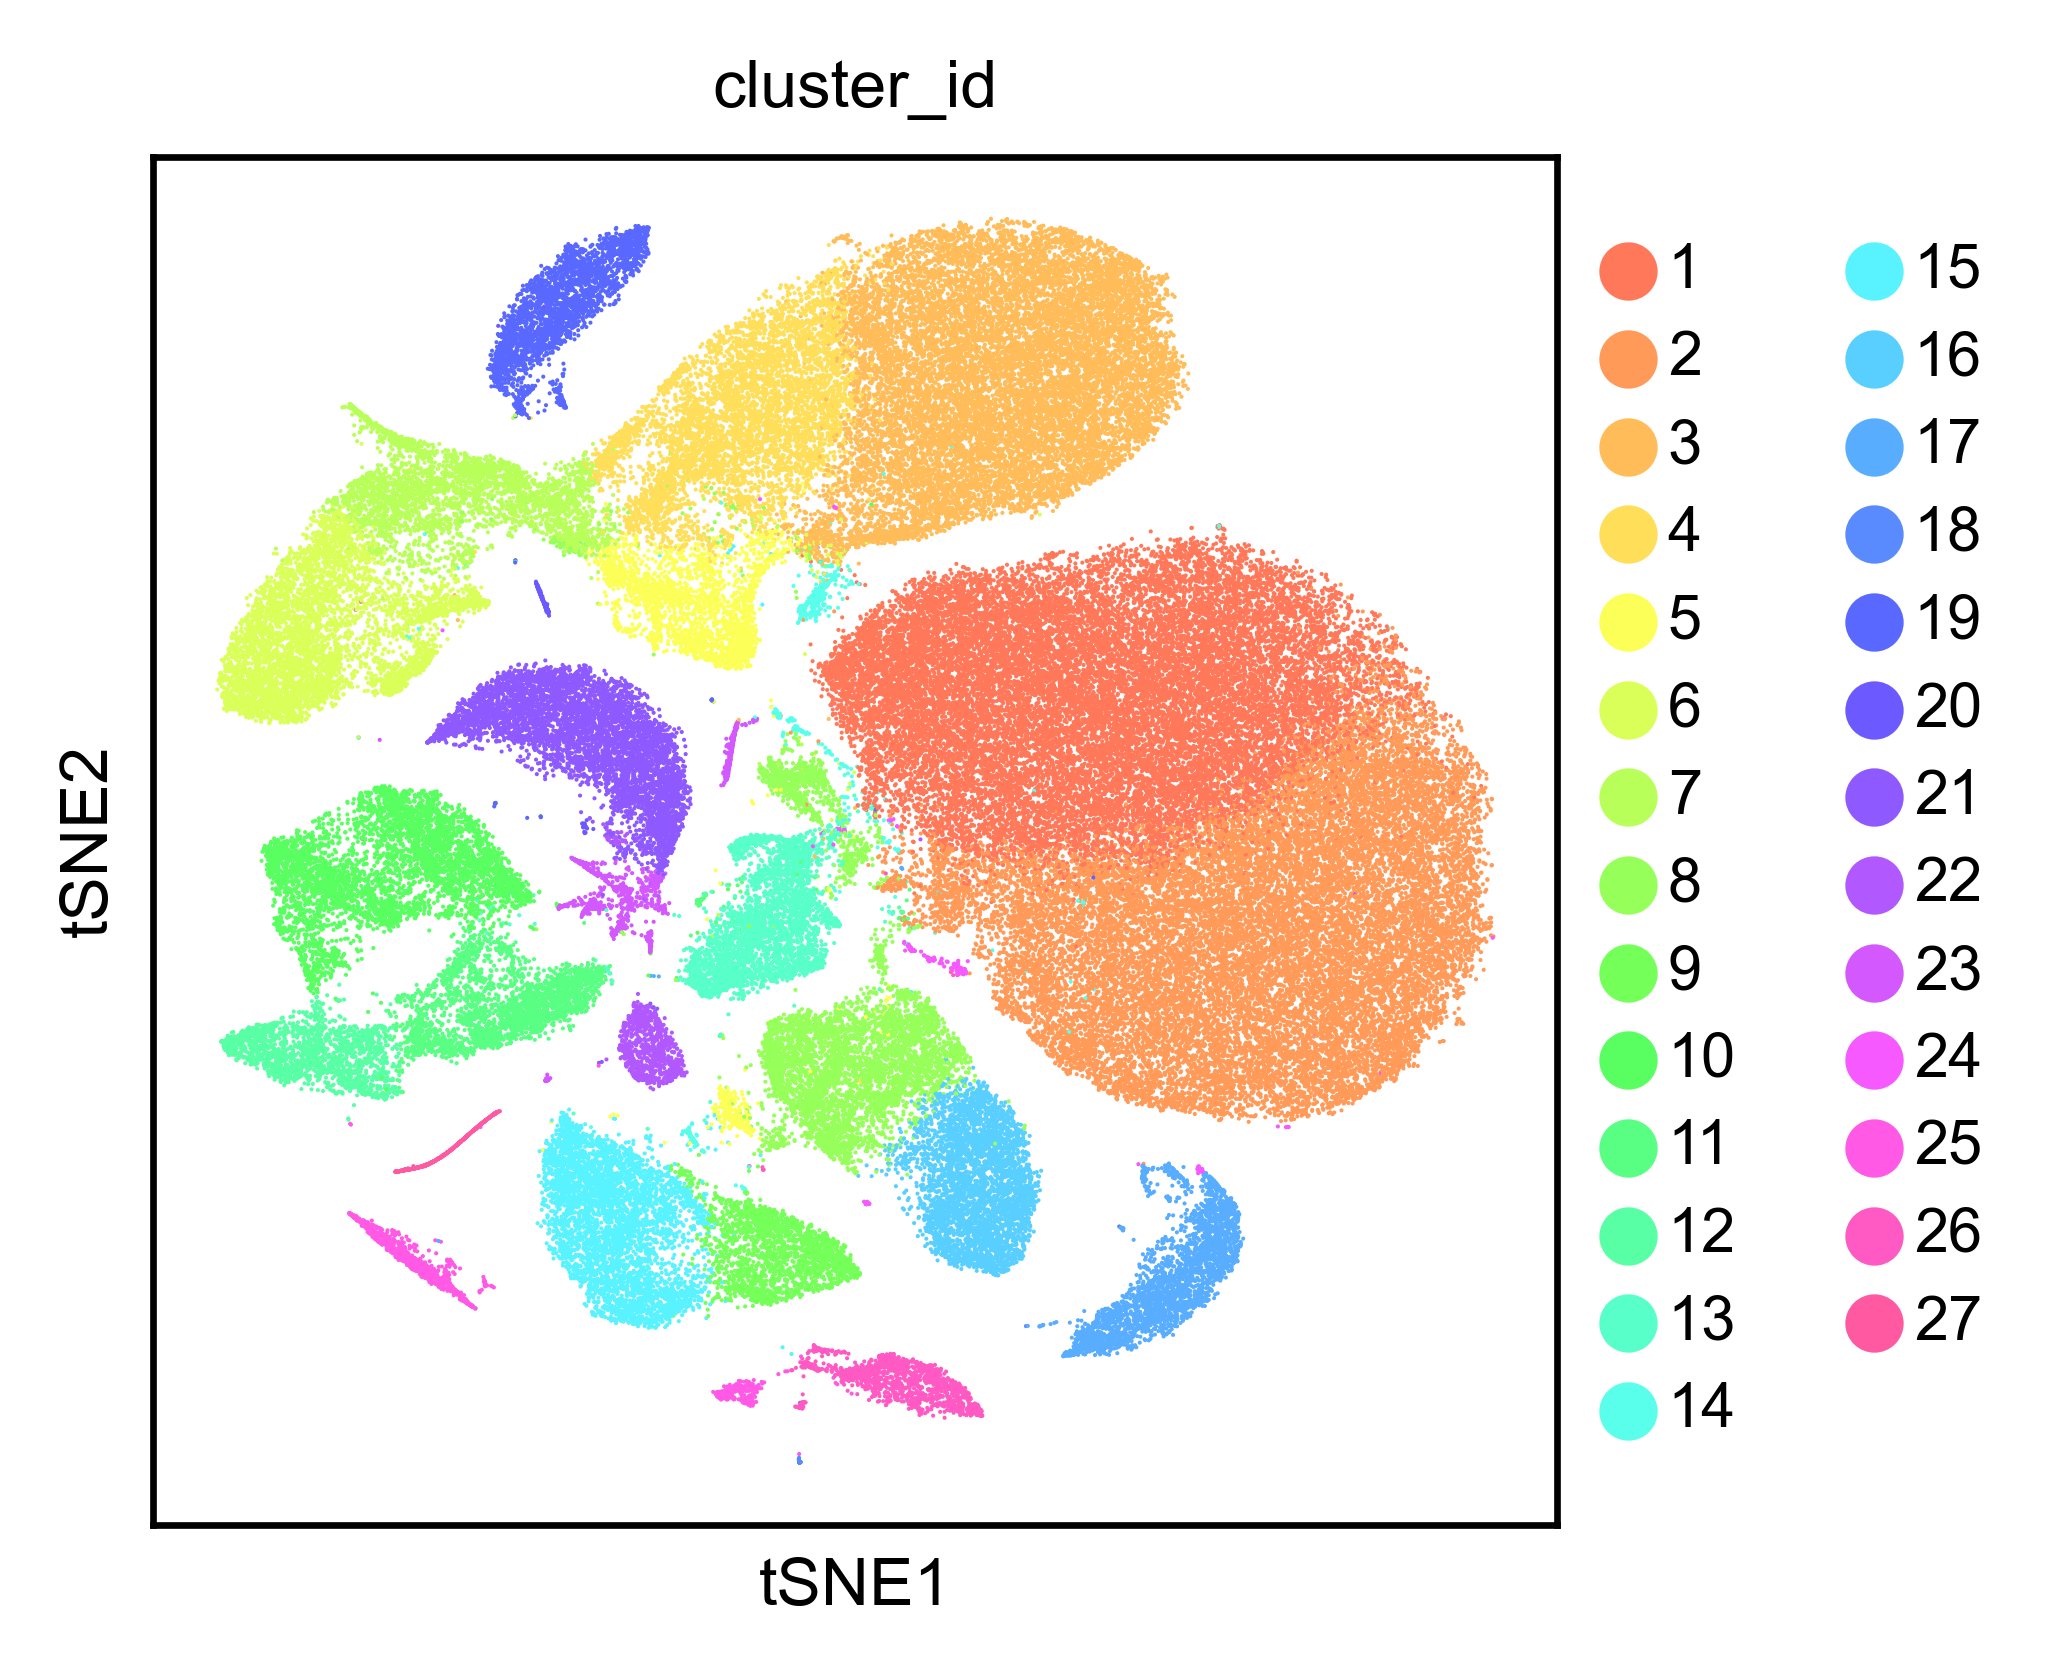

In [12]:
keys = list(np.arange(27))
seurat_id_order=[1,2,3,4,21,8,6,10,15,16,13,7,5,17,19,11,9,12,26,23,25,22,27,14,24,20,18]
seurat_id_order = [str(s) for s in seurat_id_order]
seurat_id_dict = { keys[i]:seurat_id_order[i] for i in range(len(seurat_id_order))   }
kzbg_adata.obs['cluster_id'] = [seurat_id_dict[int(c)] for c in  kzbg_adata.obs['res.0.6']]
sc.pl.tsne(kzbg_adata,color=['cluster_id'],palette=seurat_cmap(27,s=.65,v=1)) # ,legend_loc='on data'


In [ ]:
sc.pl.tsne(kzbg_adata,color=['clust_num'],palette=seurat_cmap(27,s=.65,v=1)) # ,legend_loc='on data'